<ipython-input-5-f839d543d084>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


,Model,MSE,RMSE,AIC,BIC
0,lstm_sequential_11.h5,18086.614212,134.486483,81919.635129,101752.802012
1,lstm_sequential_30.h5,23953.351065,154.768702,81923.006362,101756.173245
2,lstm_sequential_28.h5,26044.408823,161.382802,81924.010701,101757.177584
3,lstm_sequential_21.h5,31372.728891,177.123485,81926.244331,101759.411214
4,lstm_sequential_25.h5,36506.717523,191.067311,81928.063019,101761.229902
5,lstm_sequential_rmsprop_10.h5,36966.830369,192.267601,81928.213316,101761.380199
6,lstm_sequential_rmsprop_17.h5,40568.289292,201.415713,81929.328904,101762.495787
7,lstm_sequential_27.h5,42461.296188,206.061389,81929.876179,101763.043062
8,lstm_sequential_4.h5,46044.012860,214.578687,81930.848236,101764.015119
9,lstm_sequential_22.h5,47340.995808,217.579861,81931.181583,101764.348466


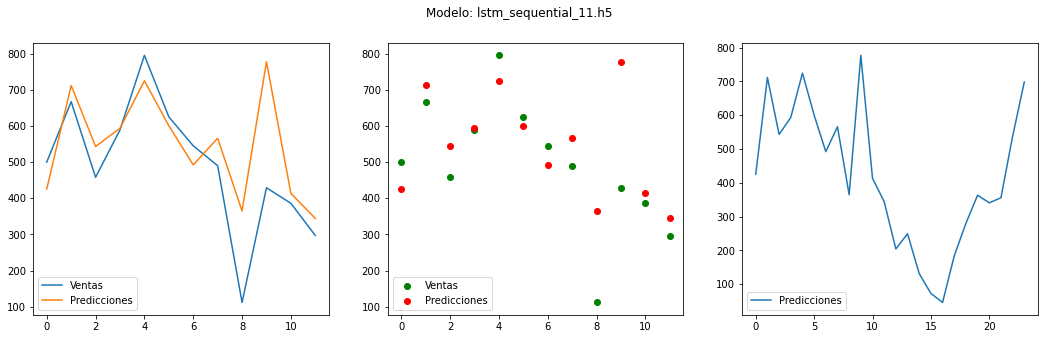

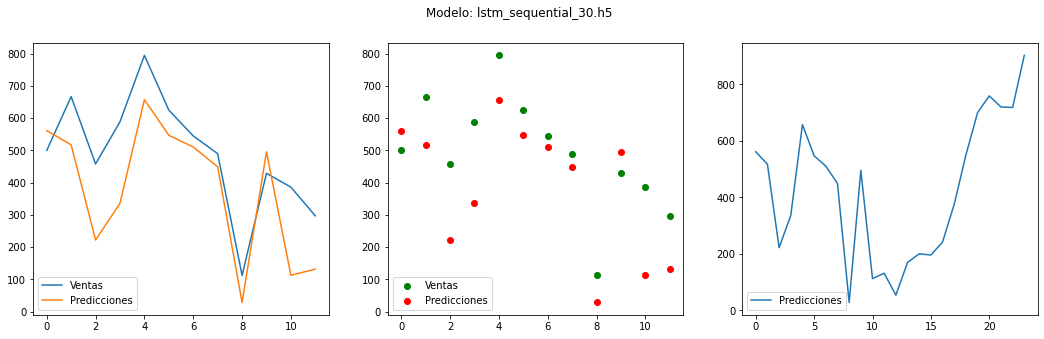

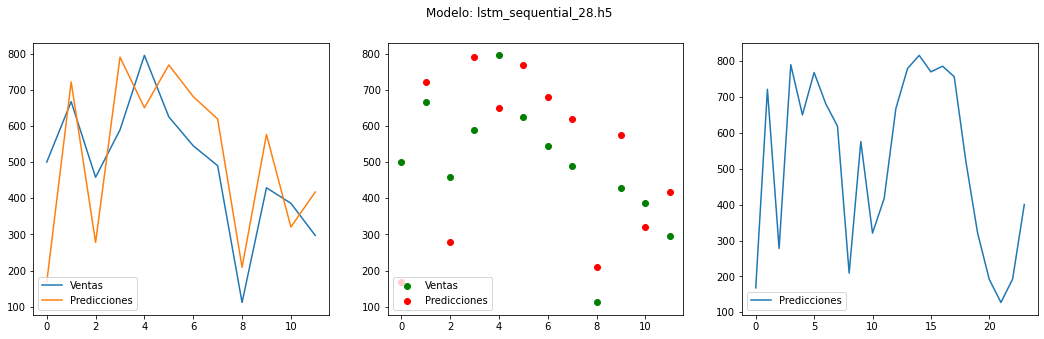

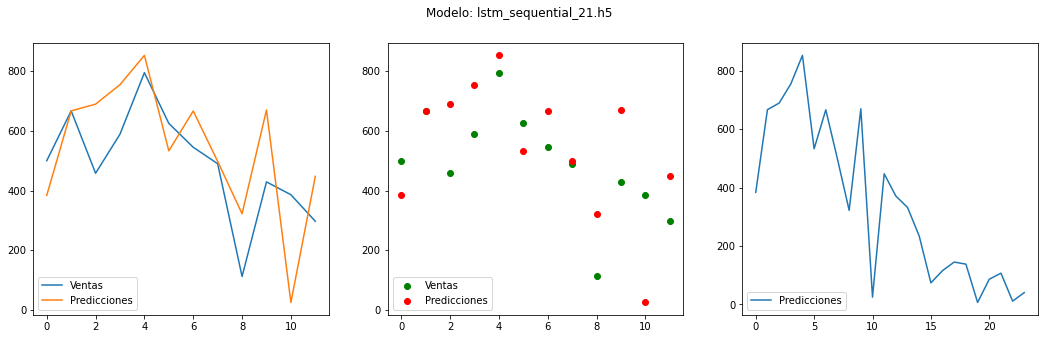

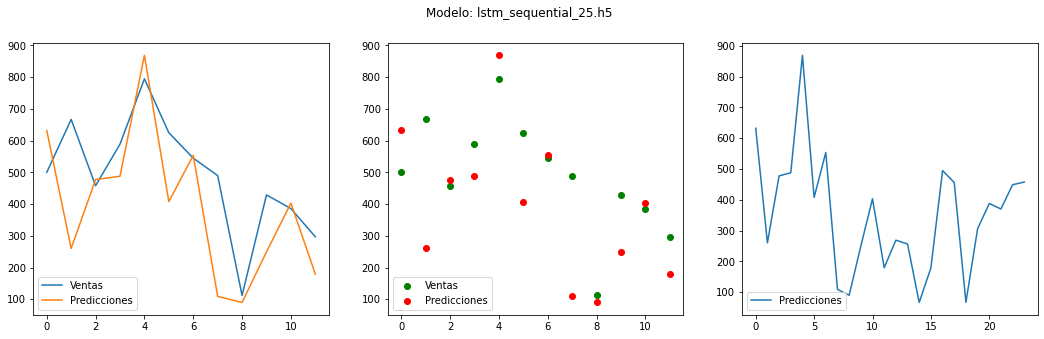

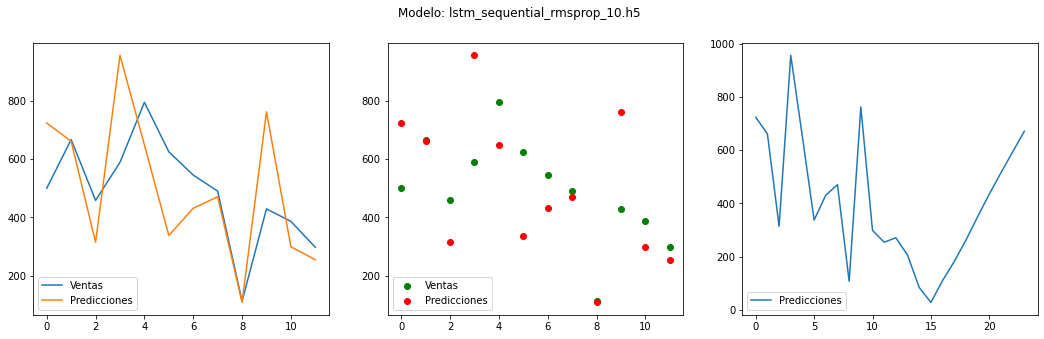

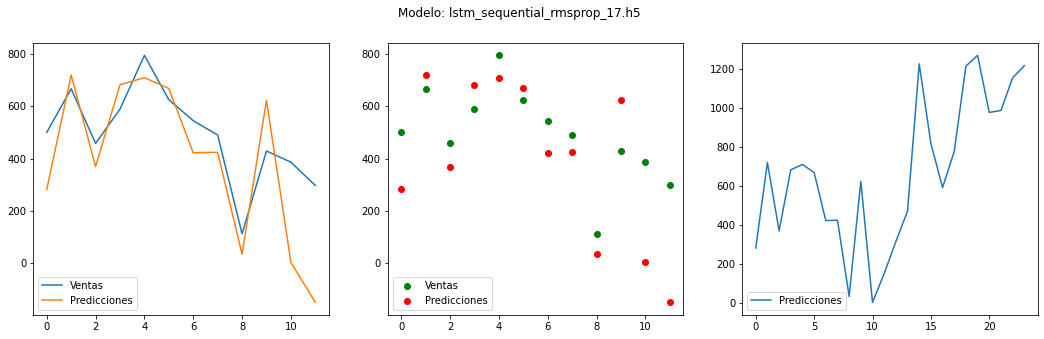

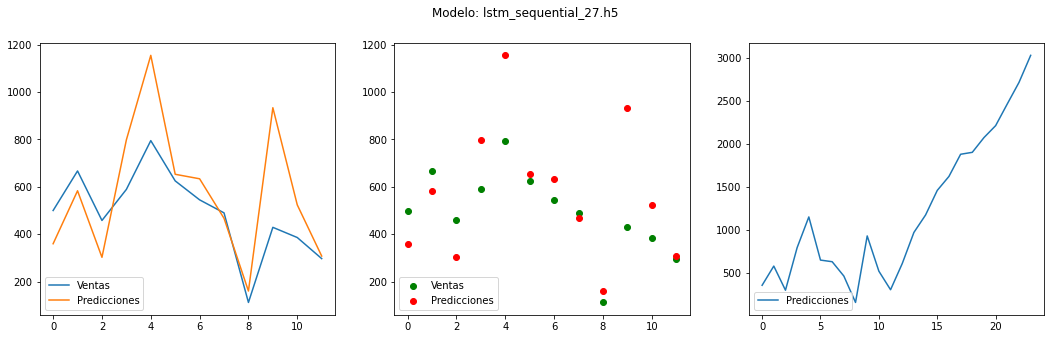

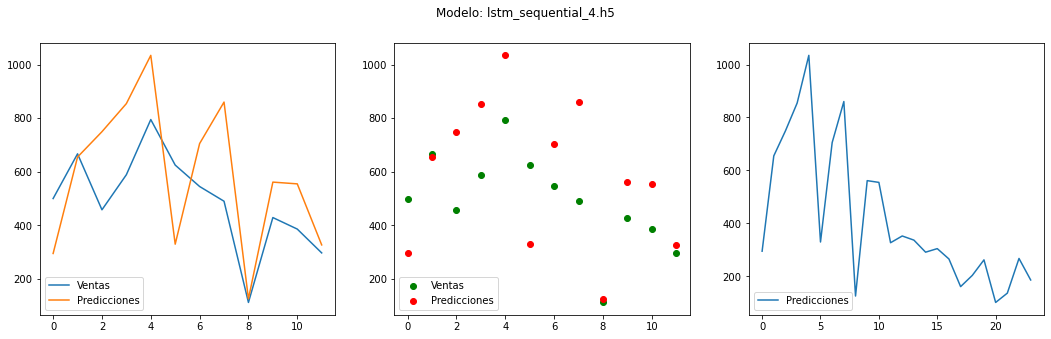

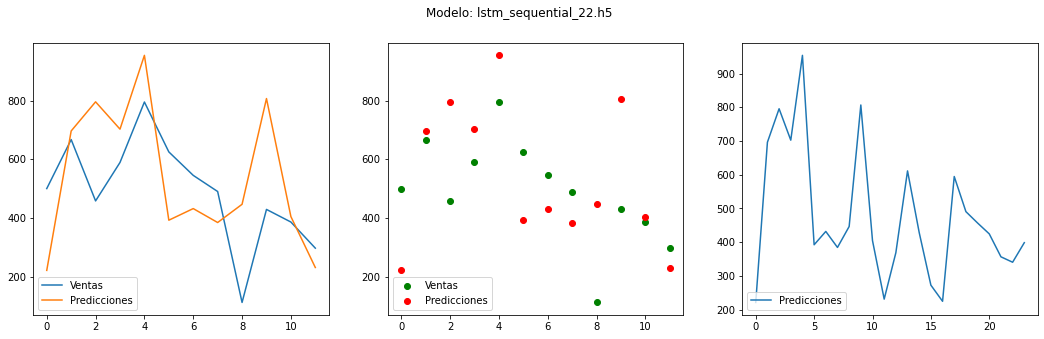

In [5]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt,log
from matplotlib import pyplot
import numpy as np
from keras.models import load_model
import glob
from operator import itemgetter
import pandas as pd
import matplotlib.pyplot as plt
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# calculate aic for regression
def calculate_aic(n, mse, num_params):
	aic = n * log(mse) + 2 * num_params
	return aic

# num_params: Number of parameters (weights and biases)
# n: Number of training cases
def calculate_bic(n, mse, num_params):
	bic = n * log(mse) + num_params * log(n)
	return bic

series = read_csv('quantity_monthly_3dmovil.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# All files starting with lstm
files = glob.glob("lstm_sequential_*")
metrics = list()
for file in files:

    new_model = load_model(file)
    
    predictions = list()
    predictions2 = list()
    expectedSales = list()
    raw_values2 = series.values
    ntest = len(test)-1
    
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    
    for i in range(24):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(new_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values2, yhat, len(test_scaled)-i)
        # store forecast
        predictions.append(yhat)
        predictions2.append(abs(yhat))

        expected = [raw_values2[len(train) + i + 1],0][i>ntest]
        expectedSales.append(expected)
        raw_values2 = [[raw_values2,
                        np.append(raw_values2,[yhat])][i==ntest]
                       ,np.append(raw_values2,[yhat])][i>ntest]
        diff_values2 = difference(raw_values2, 1)
        supervised2 = timeseries_to_supervised(diff_values2, 1)
        supervised_values2 = supervised2.values
        train2, test2 = supervised_values2[0:-12], supervised_values2[-12:]
        scaler2, train_scaled2, test_scaled2 = scale(train2, test2) 
        test_scaled = [[test_scaled,
                        np.append(test_scaled,[test_scaled2[11,0:]],axis=0)][i==ntest]
                       ,np.append(test_scaled,[test_scaled2[11,0:]],axis=0)][i>ntest]
        #scaler = [[scaler,scaler2][i==11],scaler2][i>11]

    mse = mean_squared_error(raw_values[-12:], predictions[:12])
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions[:12]))
    aic = calculate_aic(len(raw_values[-12:]), mse, new_model.count_params())
    bic = calculate_bic(len(raw_values[-12:]), mse, new_model.count_params())

    metrics.append([file,mse,rmse,aic,bic,predictions,predictions2,expectedSales,series.index])

metrics = sorted(metrics, key=itemgetter(2))

for metric in metrics[:10]:

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figheight(5)
    fig.set_figwidth(18)
    fig.suptitle("Modelo: "+ metric[0])
    ax1.plot(raw_values[-12:], label='Ventas')
    ax1.plot(metric[5][:12], label='Predicciones')
    ax1.legend(loc="lower left")
    ax2.scatter(range(len(raw_values[-12:])),raw_values[-12:],c='g', label='Ventas')
    ax2.scatter(range(len(metric[5][:12])),metric[5][:12],c='r', label='Predicciones')
    ax2.legend(loc="lower left")
    ax3.plot(metric[6], label='Predicciones')
    ax3.legend(loc="lower left")
    
    
df = pd.DataFrame(metrics[:10],columns=['Model', 'MSE', 'RMSE', 'AIC', 'BIC', 'predictions', 'predictions2','expected','fechas'])
df2 =df[['Model', 'MSE', 'RMSE', 'AIC', 'BIC']]
df2

In [6]:
#Modelo seleccionado(100 neuronas LSTM, Optimizador ADAM)

from keras.models import load_model
new_model = load_model('lstm_sequential_30.h5') #RMSE 202
new_model.summary()

prediccion = list(df.predictions[1])
meses = list(df.fechas[1])
expected = list(df.expected[1])
columns = ['Mes', 'Prediccion', 'Expected']

new = pd.DataFrame(np.column_stack([meses[-12:], prediccion[:12],expected[:12]]), index=[meses[-12:]], columns=columns)
new


Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (1, 100)                  40800     
_________________________________________________________________
dense_34 (Dense)             (1, 1)                    101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


,Mes,Prediccion,Expected
2020-09-30,2020-09-30,561.364371,500
2020-10-31,2020-10-31,517.341907,667
2020-11-30,2020-11-30,222.002291,458
2020-12-31,2020-12-31,335.872086,589
2021-01-31,2021-01-31,657.491648,795
2021-02-28,2021-02-28,547.086657,625
2021-03-31,2021-03-31,510.608377,545
2021-04-30,2021-04-30,449.006193,490
2021-05-31,2021-05-31,28.18075,112
2021-06-30,2021-06-30,495.597254,429


In [728]:
my_range = pd.date_range(
  start="2020-09-30", end="2022-08-31", freq='M')

prediccion = list(df.predictions2[1])
columns = ['Prediccion']
new = pd.DataFrame(np.column_stack([prediccion[-24:]]), index=[my_range], columns=columns)
new

,Prediccion
2020-09-30,561.364371
2020-10-31,517.341907
2020-11-30,222.002291
2020-12-31,335.872086
2021-01-31,657.491648
2021-02-28,547.086657
2021-03-31,510.608377
2021-04-30,449.006193
2021-05-31,28.180750
2021-06-30,495.597254
